# Credit Card Customer Attrition Using Machine Learning

Contributors: Orvin Bellamy (https://github.com/orvinbellamy/)

Python Version 3.8.8

Dataset by syviaw\
https://www.kaggle.com/syviaw/bankchurners

Refer to the kaggle page for the data dictionary of this dataset

Note that this notebook is still a work-in-progress

Objective:\
This machine learning model is used to predict likelihood of credit card customer churning (attrition) using logistic regression.\
See the logreg function

The dataset from Kaggle is already clean, no data cleaning is required, only the standard preprocessing procedures (standard scaler, one-hot encoding).\
Need further investigations on other variables as features and improving model accuracy.\
The dataset is too bias towards existing customers.

# Import Packages

In [34]:
# Import Packages

# For pre-processing
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# For building models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import scipy

#For accessing models 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pre-processing


In [48]:
# Reading the dataset
df = pd.read_csv('BankChurners.csv', index_col=0)
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Dataset discovery, uncomment to use

In [18]:
display(df.dtypes)

Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income_Category                                                                                                                        object
Card_C

In [ ]:
df.columns

Dropping null values

In [49]:
# dropping the null values
df.dropna(inplace = True)

In [50]:
# Create a new column for the label, attrited customers will be labeled as 1, existing customer will be labeled as 0
# df['label'] = 0
# df.loc[df['Attrition_Flag'] == 'Attrited Customer', 'label'] = 1

Splitting data for training and testing. Random_state is fixed for reproducibility, recommend removing random_state to simulate model performance multiple times.

In [51]:
features = ['Customer_Age', 'Avg_Utilization_Ratio', 'Total_Revolving_Bal', 'Total_Trans_Amt']
label = 'Attrition_Flag'

In [62]:
# Splitting the dataset before processing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=263)
X_train = train_df[features]
y_train = train_df[label]
X_test = test_df[features]
y_test = test_df[label]

Preprocessing pipeline

In [33]:
# creating the column tansformer
categorical_features = X_train.select_dtypes('object').columns
categorical_features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_features

Index(['Customer_Age', 'Avg_Utilization_Ratio', 'Total_Revolving_Bal',
       'Total_Trans_Amt'],
      dtype='object')

In [41]:
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'))]
)

numerical_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

col_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Model

Dummy model

In [70]:
# Create a dummy model for normal label and binary label

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

print("Normal label score: ", dummy.score(X_test, y_test))

Normal label score:  0.8356367226061204


3 pipelines for hyperparameter optimization

1 pipeline for normal labels (SVC), 2 pipelines for binned labels (SVC, decision tree)

In [42]:
# Create pipelines for hyperparameter optimization

## For normal labels
log_pipe = Pipeline(
    steps=[('columntransformer', col_transformer),
           ('logreg', LogisticRegression())]
)

Model for Normal Labels

In [87]:
# Create a Logistic Regression model

def logreg(train_features, train_label, test_features, test_label):
    # set a param
    param = {'logreg__C': [0.01, 0.1, 1, 10, 100, 1000]}

    # Set random_search
    # model should be changed to pipe
    grid =GridSearchCV(log_pipe, param, cv=10, n_jobs=-1, return_train_score=True)
    grid.fit(train_features, train_label)

    grid_result = pd.DataFrame(grid.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score')

    # get best parameter
    log_C = grid.best_params_['logreg__C']

    # Create new pipeline with optimized hyperparameter
    pipe_reg = Pipeline(
        steps=[('columntransformer', col_transformer),
            ('svc', LogisticRegression(C=log_C))]
    )

    # # Train and test the model
    pipe_reg.fit(train_features, train_label)
    testscore = pipe_reg.score(test_features, test_label)
    predict = pipe_reg.predict(test_features)
    proba = pipe_reg.predict_proba(test_features)

    predict_table = pd.DataFrame({'Actual': test_label.to_numpy(), 'Predicted': predict, 'Probability': proba.tolist()})

    return testscore, predict, predict_table, grid_result, proba

In [88]:
logreg_testscore, logreg_predict, df_logreg_predict, logreg_grid, logreg_proba = logreg(X_train, y_train, X_test, y_test)

Note that for the binned label, the two models svc_bin and dec_tree_bin produces the exact same test score. This is tested for multiple random_state when splitting the data. No explanation for this phenomenon yet, will investigate further.

## Model Evaluation

Model Evaluation : SVC

In [82]:
# confusion matrix to visualize the performance of the algorithm.
cm_logreg = confusion_matrix(y_test, logreg_predict)
cm_logreg

array([[   1,  332],
       [   0, 1693]], dtype=int64)

In [89]:
df_logreg_predict

,Actual,Predicted,Probability
0,Existing Customer,Existing Customer,"[0.35231114789956064, 0.6476888521004394]"
1,Existing Customer,Existing Customer,"[0.27409962039847346, 0.7259003796015265]"
2,Existing Customer,Existing Customer,"[0.14636438620020398, 0.853635613799796]"
3,Existing Customer,Existing Customer,"[0.1238579130170695, 0.8761420869829305]"
4,Existing Customer,Existing Customer,"[0.015438260033513784, 0.9845617399664862]"
...,...,...,...
2021,Existing Customer,Existing Customer,"[0.4403117232106306, 0.5596882767893694]"
2022,Existing Customer,Existing Customer,"[0.10700312814368551, 0.8929968718563145]"
2023,Attrited Customer,Existing Customer,"[0.04778391024624806, 0.9522160897537519]"
2024,Existing Customer,Existing Customer,"[0.4441071370928954, 0.5558928629071046]"


Note the confusion matrix below. The model only predicts "Sometimes" and "Never". This is likely attributed to the small training data. An experiment was done where all observations where 'work_interfere' = 'Sometimes' is removed and all the remaining classes can be predicted. This is another reason why collapsing the label into 2 classes is preferred.

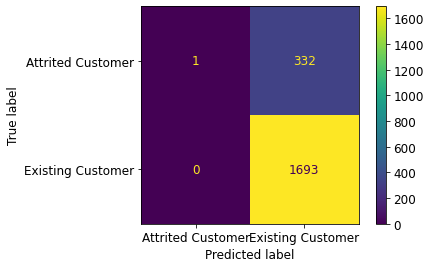

In [75]:
# Confusion Matrix plot 

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm_logreg, display_labels=['Attrited Customer', 'Existing Customer']).plot()

In [76]:
# Classification Report  
print(classification_report(
        y_test,
        logreg_predict,digits=4,
        target_names=["Attrited Customer", "Existing Customer"]))

                   precision    recall  f1-score   support

Attrited Customer     1.0000    0.0030    0.0060       333
Existing Customer     0.8360    1.0000    0.9107      1693

         accuracy                         0.8361      2026
        macro avg     0.9180    0.5015    0.4583      2026
     weighted avg     0.8630    0.8361    0.7620      2026



In [77]:
# Check for classification balance
y_train.value_counts('Attrition_Flag')

Existing Customer    0.840267
Attrited Customer    0.159733
Name: Attrition_Flag, dtype: float64